In [31]:
import largestinteriorrectangle as lir
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# 生成简单的凸多边形数据
def generate_polygon(num_points=10, scale=1.0):
    angles = np.sort(np.random.rand(num_points) * 2 * np.pi)
    points = np.stack([np.cos(angles), np.sin(angles)], axis=1) * scale
    return points.astype(np.int32)

In [3]:
polygons = np.array([generate_polygon(num_points=5, scale=100.0) for _ in range(4)])
polygons

array([[[ 79,  60],
        [-44,  89],
        [-50, -86],
        [ 32, -94],
        [ 33, -94]],

       [[ 42,  90],
        [ 16,  98],
        [-55, -83],
        [ 85, -52],
        [ 99, -12]],

       [[-48,  87],
        [-99,   4],
        [-85, -52],
        [-14, -99],
        [ 54, -84]],

       [[ 48,  87],
        [ 45,  89],
        [-87,  48],
        [-11, -99],
        [ 71, -69]]])

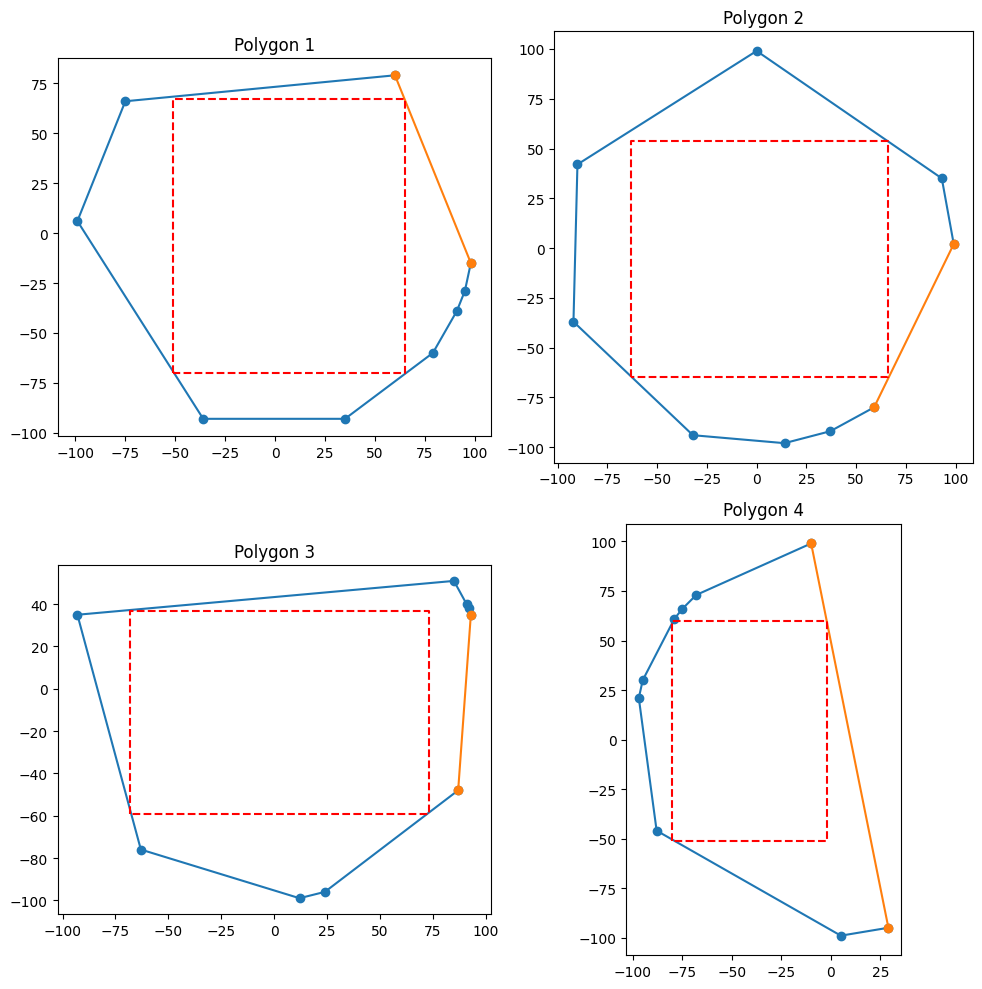

In [4]:
# 生成4个凸多边形
polygons = np.array([generate_polygon(num_points=9, scale=100.0) for _ in range(4)])

# 创建画布和子图
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# 将子图展平为一维数组
axs = axs.flatten()

# 绘制每个多边形
for i, polygon in enumerate(polygons):
    
    axs[i].plot(polygon[:, 0], polygon[:, 1], 'o-')
    axs[i].plot([polygon[-1, 0], polygon[0, 0]], [polygon[-1, 1], polygon[0, 1]], 'o-')

    point = lir.lir(polygons[i:i+1,])
    rect = np.array([(point[0],point[1]), (point[0],point[1]+point[3]-1), (point[0]+point[2]-1,point[1]+point[3]-1),(point[0]+point[2]-1,point[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    axs[i].plot(rect[:, 0], rect[:, 1], 'r--')

    
    axs[i].set_title(f'Polygon {i+1}')
    axs[i].set_aspect('equal', 'box')  # 设置坐标轴比例相同

# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()

In [5]:
# 生成训练数据 (多边形和最大内接矩形参数)
def generate_training_data(num_samples=1000):
    data = []
    for _ in range(num_samples):
        polygon = generate_polygon(num_points=9, scale=100.0)
        point = lir.lir(np.array([polygon]))
        (point[0]+point[2]-1,point[1]+point[3]-1)
        data.append((polygon.flatten(), np.array([point[0], point[1], point[2], point[3]])))
    return data

In [ ]:
temp = generate_training_data(num_samples=1)

In [ ]:
temp

In [ ]:
np.array(temp,dtype=object)/100

In [6]:
train_data = generate_training_data(20000)

In [32]:
train_data[0:1]

[(array([ 93,  34,  24,  96, -42,  90, -99,  10, -92, -38, -81, -57, -16,
         -98,  49, -87,  50, -86]),
  array([-58, -72, 114, 141]))]

In [35]:
X_train = torch.tensor([x[0] for x in train_data], dtype=torch.float32)

In [36]:
y_train = torch.tensor([x[1] for x in train_data], dtype=torch.float32)

In [38]:
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [41]:
# 简单的全连接神经网络
class RectNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(RectNet, self).__init__()
        # self.fc1 = nn.Linear(input_size, 128)
        # self.fc2 = nn.Linear(128, 64)
        # self.fc3 = nn.Linear(64, output_size)
        self.model = nn.Sequential(
            # expand 1 to 10 filters
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),       
            nn.LeakyReLU(0.02),
            nn.Dropout(0.5),      # Dropout 层
        
            # 10 filters to 10 filters
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),          
            nn.LeakyReLU(0.02),    
            nn.Dropout(0.3),      # Dropout 层
            nn.Linear(64, output_size)
        )
        
    def forward(self, x):
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = self.fc3(x)
        # return x
        return self.model(x)


# 生成训练数据
# train_data = generate_training_data(10000)
# X_train = torch.tensor([x[0] for x in train_data], dtype=torch.float32)
# y_train = torch.tensor([x[1] for x in train_data], dtype=torch.float32)

In [42]:
# 创建模型和优化器
model = RectNet(input_size=X_train.shape[1], output_size=4)

In [43]:
# 优化器 - Adam，学习率为0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 学习率调度器 - 每10个epoch降低学习率
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.MSELoss()

In [44]:
# 训练模型
def train(model, dataloader, criterion, optimizer, scheduler, num_epochs=50):
    model.train()  # 训练模式
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()  # 清空梯度
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            
            # 反向传播
            loss.backward()
            
            # 梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()  # 更新权重
            
            running_loss += loss.item()
        
        # 学习率调度
        scheduler.step()
        
        # 打印每个epoch的平均损失
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

# train(model, dataloader, criterion, optimizer, scheduler, num_epochs=100)

In [ ]:
# 训练模型
epochs = 1000
for epoch in range(epochs):
    for item in range(0, len(X_train), 1000):
        model.train()
        optimizer.zero_grad()
        
        # 前向传播 
        output = model(X_train[item:item+1000])
        
        # 计算损失 (这里只是简单的MSE损失，可以加入面积最大化和边界约束损失)
        loss = criterion(output, y_train[item:item+1000])
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {epoch} , Loss: {loss.item()}')

In [ ]:
polygons = np.array([generate_polygon(num_points=9, scale=100.0) for _ in range(4)])
polygons = polygons/100

In [ ]:
test_input = torch.tensor(polygons[0].flatten(), dtype=torch.float32).unsqueeze(0)
test_input, X_train[0:1]

In [ ]:
model(test_input)

In [ ]:
model( X_train[0:1])

In [ ]:
# 测试
model.eval()
with torch.no_grad():
    test_polygon = generate_polygon(num_points=9, scale=100.0)
    test_polygon = test_polygon/100
    test_input = torch.tensor(test_polygon.flatten(), dtype=torch.float32).unsqueeze(0)
    print(test_input)
    pred_rect_params = model(test_input).squeeze().numpy()
    print(pred_rect_params)

In [ ]:
polygons = np.array([generate_polygon(num_points=9, scale=100.0) for _ in range(4)])
polygons/100

In [ ]:
model.eval()
with torch.no_grad():
    test_input = torch.tensor(polygons[0].flatten(), dtype=torch.float32).unsqueeze(0)
    point = model(test_input).squeeze().numpy()
    print(point)

[-54.025604 -50.907883 118.16406  107.88851 ]
[-68.78323 -59.03691 136.9389  118.7757 ]
[-57.533176 -40.090866 120.108444 104.3256  ]
[-58.158363 -57.13642  127.29704  104.26061 ]


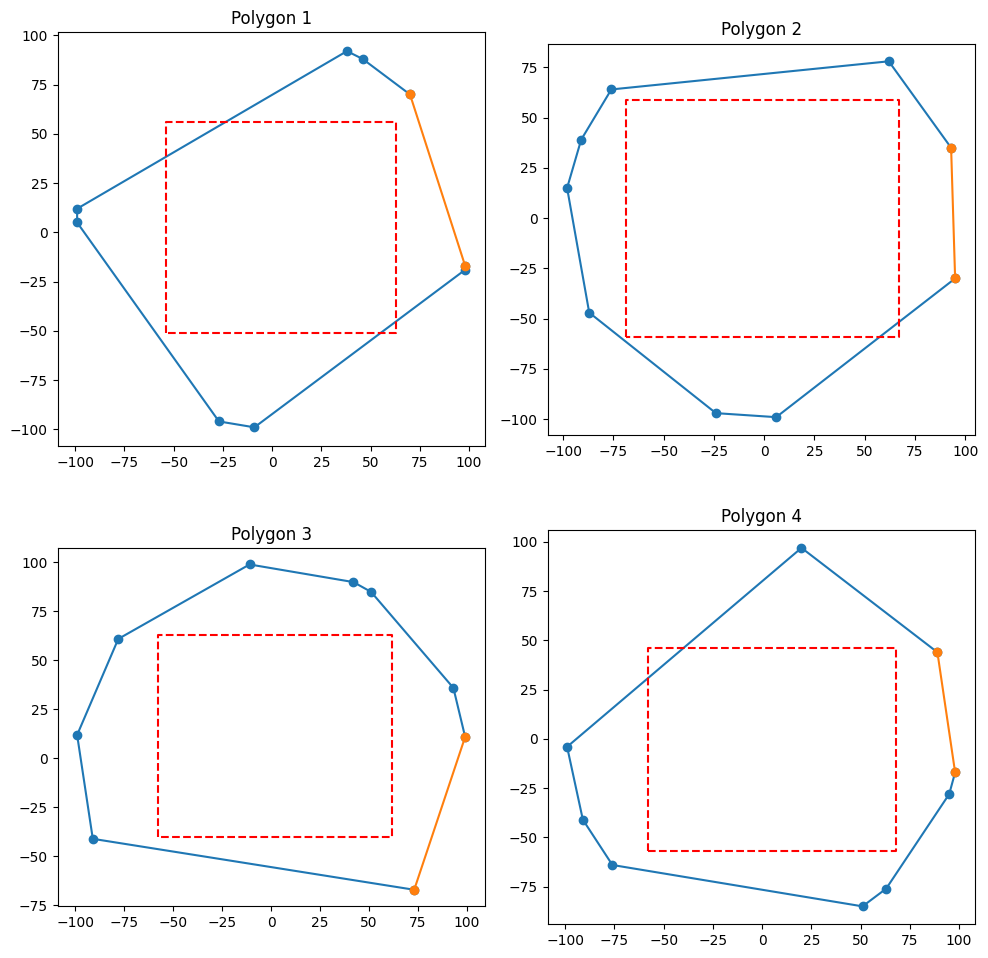

In [57]:
# 生成4个凸多边形
model.eval()
polygons = np.array([generate_polygon(num_points=9, scale=100) for _ in range(4)])
# polygons = np.array(X_train[4:8].view(4,9,2))
#polygons = polygons/100
# 创建画布和子图
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# 将子图展平为一维数组
axs = axs.flatten()

# 绘制每个多边形
for i, polygon in enumerate(polygons):
    
    axs[i].plot(polygon[:, 0], polygon[:, 1], 'o-')
    axs[i].plot([polygon[-1, 0], polygon[0, 0]], [polygon[-1, 1], polygon[0, 1]], 'o-')
    
    # point = lir.lir(polygons[i:i+1,])
    point = None
    with torch.no_grad():
        test_input = torch.tensor(polygon.flatten(), dtype=torch.float32).unsqueeze(0)
        point = model(test_input).squeeze().numpy()
        print(point)
    rect = np.array([(point[0],point[1]), (point[0],point[1]+point[3]-1), (point[0]+point[2]-1,point[1]+point[3]-1),(point[0]+point[2]-1,point[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    axs[i].plot(rect[:, 0], rect[:, 1], 'r--')

    
    axs[i].set_title(f'Polygon {i+1}')
    axs[i].set_aspect('equal', 'box')  # 设置坐标轴比例相同

# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()